In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

In [2]:
# Load data
df = pd.read_csv('hit5_clean_deduped.csv')
number_columns = ['Num1', 'Num2', 'Num3', 'Num4', 'Num5']
all_possible_numbers = range(1, 43)

In [3]:
# Build a feature table: Each row = (draw_idx, number), columns = features
feature_rows = []
for i in range(10, len(df)-1):  # start at 10 to enable window-based stats
    prev_window = df[number_columns].iloc[:i]
    this_draw = set(df.loc[i+1, number_columns])  # next draw (for label)
    for n in all_possible_numbers:
        # Features
        freq = prev_window.apply(lambda row: n in row.values, axis=1).sum()  # freq up to this draw
        last_hit = prev_window.apply(lambda row: n in row.values, axis=1)[::-1].idxmax()
        gap = i - last_hit if last_hit >= 0 else i
        window_freq = prev_window.tail(20).apply(lambda row: n in row.values, axis=1).sum()
        # Hot/Warm/Cold category by mean gap (precomputed)
        gaps = []
        indices = prev_window.apply(lambda row: n in row.values, axis=1)
        hit_indices = list(np.where(indices)[0])
        if hit_indices:
            for j in range(len(hit_indices)):
                if j == 0: gaps.append(hit_indices[j])
                else: gaps.append(hit_indices[j] - hit_indices[j-1])
            mean_gap = np.mean(gaps)
        else:
            mean_gap = i
        # Assign category
        category = 'warm'
        avg_gap = 8.26
        std_gap = 1.76
        if mean_gap < (avg_gap - std_gap): category = 'hot'
        elif mean_gap > (avg_gap + std_gap): category = 'cold'
        # Label: was n in NEXT draw?
        label = int(n in this_draw)
        feature_rows.append({
            'draw': i,
            'number': n,
            'freq': freq,
            'gap': gap,
            'window_freq': window_freq,
            'category': category,
            'label': label
        })


In [4]:
features_df = pd.DataFrame(feature_rows)

In [5]:
# Encode category
features_df['category_code'] = features_df['category'].map({'hot': 2, 'warm': 1, 'cold': 0})


In [6]:
# Train/test split
train = features_df[features_df['draw'] < int(features_df['draw'].max() * 0.8)]
test  = features_df[features_df['draw'] >= int(features_df['draw'].max() * 0.8)]

In [7]:
X_train = train[['freq','gap','window_freq','category_code']]
y_train = train['label']
X_test  = test[['freq','gap','window_freq','category_code']]
y_test  = test['label']

In [8]:
# Train simple model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:,1]

In [9]:
print(classification_report(y_test, pred, digits=2))
print("AUC:", roc_auc_score(y_test, proba))
feature_importance = dict(zip(X_train.columns, clf.feature_importances_))
print("Feature importances:", feature_importance)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1369
           1       0.08      0.04      0.05       185

    accuracy                           0.83      1554
   macro avg       0.48      0.49      0.48      1554
weighted avg       0.78      0.83      0.81      1554

AUC: 0.48388249462025945
Feature importances: {'freq': np.float64(0.3732118306654862), 'gap': np.float64(0.42090319858425584), 'window_freq': np.float64(0.12726002103326983), 'category_code': np.float64(0.07862494971698818)}


In [10]:
# Analyze Pick Frequencies

# Frequency of each number in all draws
all_drawn_numbers = pd.concat([df[col] for col in number_columns], ignore_index=True)
frequency = all_drawn_numbers.value_counts().sort_index()

print("Pick frequency for each number:")
print(frequency)


Pick frequency for each number:
1     21
2     14
3     25
4     22
5     21
6     18
7     19
8     19
9     22
10    22
11    25
12    30
13    21
14    24
15    17
16    18
17    21
18    23
19    22
20    17
21    23
22    22
23    23
24    22
25    19
26    17
27    23
28    25
29    24
30    26
31    19
32    26
33    17
34    22
35    24
36    22
37    17
38    30
39    21
40    23
41    22
42    12
Name: count, dtype: int64


/var/folders/72/gln7wlpd0tscwtzdjt7wgslr0000gn/T/ipykernel_43864/2377367151.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results['random'], results['top_freq'],


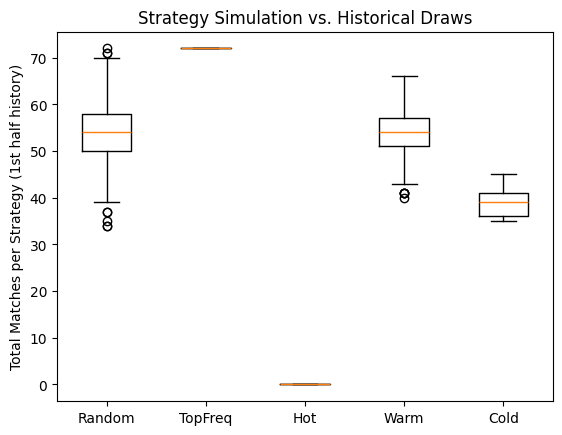

In [11]:
# Simulate Strategy vs. History

# Prepare actual draws for simulation
actual_draws = df[number_columns].apply(lambda x: set(x), axis=1)

# Basic strategies -- feel free to add more
def random_pick(pool, n=5):
    return set(np.random.choice(list(pool), n, replace=False))

def top_freq_pick(frequency, n=5):
    return set(frequency.sort_values(ascending=False).head(n).index)

# Simulate hits for each strategy
pool = range(1, 43)
n_trials = 1000

results = {'random': [], 'top_freq': [], 'hot': [], 'warm': [], 'cold': []}
# Hot/Warm/Cold categories from previous result or recalculate here as needed
hot = frequency[frequency > frequency.mean() + frequency.std()].index.tolist()
warm = frequency[(frequency >= frequency.mean() - frequency.std()) & 
                 (frequency <= frequency.mean() + frequency.std())].index.tolist()
cold = frequency[frequency < frequency.mean() - frequency.std()].index.tolist()

for i in range(n_trials):
    # Try to match against the first half of historical draws
    hist_draws = actual_draws[:len(actual_draws)//2]
    # Random strategy
    random_combo = random_pick(pool)
    random_hits = sum(len(random_combo.intersection(draw)) for draw in hist_draws)
    # Top frequency strategy
    top_combo = top_freq_pick(frequency)
    top_hits = sum(len(top_combo.intersection(draw)) for draw in hist_draws)
    # Hot strategy (if at least 5 numbers)
    hot_combo = set(np.random.choice(hot, 5, replace=False)) if len(hot) >= 5 else set()
    hot_hits = sum(len(hot_combo.intersection(draw)) for draw in hist_draws)
    # Warm strategy
    warm_combo = set(np.random.choice(warm, 5, replace=False)) if len(warm) >= 5 else set()
    warm_hits = sum(len(warm_combo.intersection(draw)) for draw in hist_draws)
    # Cold strategy
    cold_combo = set(np.random.choice(cold, 5, replace=False)) if len(cold) >= 5 else set()
    cold_hits = sum(len(cold_combo.intersection(draw)) for draw in hist_draws)

    results['random'].append(random_hits)
    results['top_freq'].append(top_hits)
    results['hot'].append(hot_hits)
    results['warm'].append(warm_hits)
    results['cold'].append(cold_hits)

import matplotlib.pyplot as plt
plt.boxplot([results['random'], results['top_freq'], 
             results['hot'], results['warm'], results['cold']], 
            labels=['Random','TopFreq','Hot','Warm','Cold'])
plt.ylabel('Total Matches per Strategy (1st half history)')
plt.title('Strategy Simulation vs. Historical Draws')
plt.show()


In [12]:


for strat in results:
    arr = np.array(results[strat])
    print(f"Strategy: {strat}")
    print(f"  Mean:  {arr.mean():.2f}")
    print(f"  Median: {np.median(arr):.2f}")
    print(f"  Std Dev: {arr.std():.2f}")
    print(f"  Min: {arr.min()}")
    print(f"  Max: {arr.max()}")
    print(f"  Sample: {arr[:10]}")  # Show first 10 for example
    print("---------------------------")


Strategy: random
  Mean:  53.94
  Median: 54.00
  Std Dev: 5.90
  Min: 34
  Max: 72
  Sample: [53 53 50 49 51 58 51 46 54 54]
---------------------------
Strategy: top_freq
  Mean:  72.00
  Median: 72.00
  Std Dev: 0.00
  Min: 72
  Max: 72
  Sample: [72 72 72 72 72 72 72 72 72 72]
---------------------------
Strategy: hot
  Mean:  0.00
  Median: 0.00
  Std Dev: 0.00
  Min: 0
  Max: 0
  Sample: [0 0 0 0 0 0 0 0 0 0]
---------------------------
Strategy: warm
  Mean:  54.31
  Median: 54.00
  Std Dev: 4.47
  Min: 40
  Max: 66
  Sample: [56 48 52 47 52 56 52 52 66 59]
---------------------------
Strategy: cold
  Mean:  38.63
  Median: 39.00
  Std Dev: 2.77
  Min: 35
  Max: 45
  Sample: [36 37 35 37 35 35 36 41 41 45]
---------------------------


In [13]:
def mixed_pick(hot, warm, cold):
    # Choose N_hot, N_warm, N_cold -- adjust these as desired
    N_hot = min(1, len(hot))   # Adjust if not enough hot numbers
    N_warm = min(3, len(warm))
    N_cold = min(1, len(cold))
    pick = []
    if N_hot > 0: pick += list(np.random.choice(hot, N_hot, replace=False))
    if N_warm > 0: pick += list(np.random.choice(warm, N_warm, replace=False))
    if N_cold > 0: pick += list(np.random.choice(cold, N_cold, replace=False))
    return set(pick)

results['mixed'] = []
n_trials = 1000
hist_draws = actual_draws[:len(actual_draws)//2]  # As before

for i in range(n_trials):
    mixed_combo = mixed_pick(hot, warm, cold)
    mixed_hits = sum(len(mixed_combo.intersection(draw)) for draw in hist_draws)
    results['mixed'].append(mixed_hits)

In [14]:
for strat in results:
    arr = np.array(results[strat])
    print(f"Strategy: {strat}")
    print(f"  Mean:  {arr.mean():.2f}")
    print(f"  Median: {np.median(arr):.2f}")
    print(f"  Std Dev: {arr.std():.2f}")
    print(f"  Min: {arr.min()}")
    print(f"  Max: {arr.max()}")
    print(f"  Sample: {arr[:10]}")
    print("---------------------------")

Strategy: random
  Mean:  53.94
  Median: 54.00
  Std Dev: 5.90
  Min: 34
  Max: 72
  Sample: [53 53 50 49 51 58 51 46 54 54]
---------------------------
Strategy: top_freq
  Mean:  72.00
  Median: 72.00
  Std Dev: 0.00
  Min: 72
  Max: 72
  Sample: [72 72 72 72 72 72 72 72 72 72]
---------------------------
Strategy: hot
  Mean:  0.00
  Median: 0.00
  Std Dev: 0.00
  Min: 0
  Max: 0
  Sample: [0 0 0 0 0 0 0 0 0 0]
---------------------------
Strategy: warm
  Mean:  54.31
  Median: 54.00
  Std Dev: 4.47
  Min: 40
  Max: 66
  Sample: [56 48 52 47 52 56 52 52 66 59]
---------------------------
Strategy: cold
  Mean:  38.63
  Median: 39.00
  Std Dev: 2.77
  Min: 35
  Max: 45
  Sample: [36 37 35 37 35 35 36 41 41 45]
---------------------------
Strategy: mixed
  Mean:  55.18
  Median: 55.00
  Std Dev: 4.39
  Min: 41
  Max: 69
  Sample: [56 63 59 54 50 59 59 54 49 59]
---------------------------
